# Preprocessing of CLL DNA Methylation Data
The experiment was done with human donors. We have blood from healthly donors (HD), some precursor to CLL called MBL and 

In [1]:
import pandas as pd
import numpy as np
import h5py, os, sys
import mygene
import networkx as nx
import umap

sys.path.append(os.path.abspath('../GCN'))
import gcnPreprocessing
import gcnIO

import matplotlib.pyplot as plt
plt.rc('font', family='Times New Roman')
import seaborn as sns
%matplotlib inline

## Parameters
* `ppi_network_to_use`: Which underlying PPI network to use (can be [CPDB](http://cpdb.molgen.mpg.de/CPDB), [IREF](http://irefindex.org/wiki/index.php?title=iRefIndex) or Multinet)
* `use_only_blood_cancer_genes`: Whether or not to remove non-blood cancer genes according to [COSMIC CGC](https://cancer.sanger.ac.uk/cosmic/download) from the positive labels (known cancer genes) or not (True for using only blood cancer genes, False for using all known cancer genes)
* `label_source`: Which source to use for the positive labels (known cancer genes). This can come from either the [NCG](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1612-0) or a literature mining approach called [DigSEE](http://210.107.182.61/digseeOld/). While the NCG known cancer genes represent a manually curated list with pan-cancer genes, this source is highly biased to over-studied genes and mutations. DigSEE genes, on the other hand, are only mined from PubMed abstracts and therefore much less reliable but on the other hand less biased. DigSEE enables to look for the evidence that leads to a cancer and therefore options for this variable are: _NCG_, _expression_, _mutation_, _digsee_all_
* `minimum_degree_negatives`: Set a minimum node degree for the negative examples (non-cancer genes) in order to avoid learning mostly node degrees of genes (can be very informative)

In [2]:
# PARAMETERS
ppi_network_to_use ='IREF'
use_only_blood_cancer_genes = True
label_source = 'wu'
minimum_degree_negatives = 1
average_patients = False

## Functions

In [3]:
def get_gene_symbols(list_of_ensembl_ids):
    # get Ensembl IDs for gene names
    mg = mygene.MyGeneInfo()
    res = mg.querymany(list_of_ensembl_ids,
                       scopes='ensembl.gene',
                       fields='symbol',
                       species='human', returnall=True
                      )

    def get_symbol_and_ensembl(d):
        if 'symbol' in d:
            return [d['query'], d['symbol']]
        else:
            return [d['query'], None]

    node_names = [get_symbol_and_ensembl(d) for d in res['out']]
    # now, retrieve the names and IDs from a dictionary and put in DF
    node_names = pd.DataFrame(node_names, columns=['Ensembl_ID', 'Symbol']).set_index('Ensembl_ID')
    node_names.dropna(axis=0, inplace=True)
    return node_names

def get_ensembl_ids(list_of_gene_symbols):
    # get Ensembl IDs for gene names
    mg = mygene.MyGeneInfo()
    res = mg.querymany(list_of_gene_symbols,
                       scopes='symbol, refseq, uniprot',
                       fields='ensembl.gene',
                       species='human', returnall=True
                      )

    # now, retrieve the names and IDs from a dictionary and put in DF
    def get_name_and_id(x):
        if 'ensembl' in x:
            ens_id = x['ensembl'][0]['gene'] if type(x['ensembl']) is list else x['ensembl']['gene']
            symbol = x['query']
            return [symbol, ens_id]
        else:
            return [x['query'], None]

    ens_ids = [get_name_and_id(x) for x in res['out']]
    
    node_names = pd.DataFrame(ens_ids, columns=['Symbol', 'Ensembl_ID']).set_index('Ensembl_ID')
    node_names.dropna(axis=0, inplace=True)
    node_names.drop_duplicates(inplace=True)
    return node_names

## Load the data and join gene map with DNA methylation

In [4]:
meth_data = pd.read_csv('../data/CLL/all_data.bed', sep='\t')
meth_data.columns = ['chr'] + meth_data.columns[1:].tolist()
cpg2gene_map = pd.read_csv('../data/CLL/pos2gene.txt.gz', sep='\t', compression='gzip', header=None,
                           names=['chr', 'start', 'end', 'gene', 'location'])
meth_data_genenames = meth_data.merge(cpg2gene_map, left_on=['chr', 'start', 'end'], right_on=['chr', 'start', 'end'])
meth_data_genenames.head()

,chr,start,end,HD_1,HD_2,HD_3,HD_4,HD_5,MBL_unmut_1,MBL_unmut_16,...,MBL_2958,MBL_2781,MBL_3036,CLL_2443,CLL_2918,CLL_2958,CLL_2781,CLL_3036,gene,location
0,chr1,10496,10498,0.780,0.820,0.925,1.000,0.885,0.875,1.000,...,0.722,1.000,1.000,0.950,1.000,0.682,1.000,0.966,DDX11L1,promoter
1,chr1,10524,10526,0.959,0.978,1.000,0.958,0.926,1.000,0.983,...,0.985,1.000,1.000,0.979,0.952,0.956,1.000,1.000,DDX11L1,promoter
2,chr1,10541,10543,0.982,0.955,0.964,0.916,0.939,0.960,0.951,...,0.985,0.984,0.976,0.980,0.975,0.985,1.000,1.000,DDX11L1,promoter
3,chr1,10562,10564,0.905,0.922,0.964,0.895,0.839,0.920,0.983,...,0.782,0.809,1.000,0.850,0.951,0.828,0.838,0.984,DDX11L1,promoter
4,chr1,10570,10572,0.976,0.977,0.982,0.937,0.963,0.960,0.983,...,0.985,0.968,0.952,1.000,0.991,0.985,0.983,1.000,DDX11L1,promoter


## Clean Data

In [5]:
# select promoters only
promonly = meth_data_genenames[meth_data_genenames.location != 'genebody']
msg = "Selected only unambigous promoter CpG sites. Left with {} CpG sites for {} genes"
print (msg.format(promonly.shape[0], promonly.gene.nunique()))
"""
# drop CpG sites with more than n percent NAs
na_removed = promonly.dropna(axis=0, thresh=imputation_threshold*(promonly.shape[1]-5))
msg = "Dropped {} (left with {}) CpG sites because they contained too many NAs"
print (msg.format(promonly.shape[0]-na_removed.shape[0], na_removed.shape[0]))
"""
print ()

Selected only unambigous promoter CpG sites. Left with 1546225 CpG sites for 30703 genes



## Compute Gene $\times$ Sample Matrix and Impute

In [6]:
gene_sample_average = promonly.drop(['start', 'end', 'chr', 'location'], errors='ignore', axis=1).groupby('gene').median()

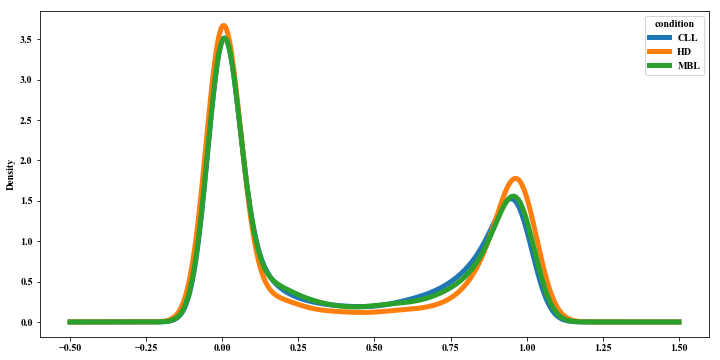

In [7]:
sample_gene_average = gene_sample_average.T
sample_gene_average['condition'] = [i[0] for i in sample_gene_average.index.str.split('_')]
sample_gene_average.groupby('condition').mean().T.plot(kind='kde', figsize=(12, 6), lw=5)

## Normalize using the healthy donors

In [8]:
print (gene_sample_average.shape)
gene_sample_average.dropna(subset=['HD_{}'.format(i) for i in range(1, 6)], axis=0, thresh=0.5, inplace=True)
print (gene_sample_average.shape)

(30703, 114)
(28984, 114)


In [9]:
healthy_donors_cols = ['HD_{}'.format(i) for i in range(1, 6)]
healthy_donors_mean = gene_sample_average[healthy_donors_cols].mean(axis=1)

gene_sample_average_norm = gene_sample_average.drop(healthy_donors_cols, axis=1).subtract(healthy_donors_mean, axis=0)
gene_sample_average_norm.shape

(28984, 109)

## Average patients together
At the same time, we want to preserve the condition (MBL, CLL), time points and the IGHV mutation status (here called 'aggressiveness')

In [10]:
sample_gene_average = gene_sample_average_norm.T.copy()
sample_gene_average['condition'] = [i[0] for i in sample_gene_average.index.str.split('_')]
def _get_agressiveness(name):
    if 'unmut' in name.split('_')[1]:
        return 'unmut' 
    elif name.split('_')[1] == 'mut':
        return 'mut'
    else:
        return 'unknown'
sample_gene_average['aggressiveness'] = [_get_agressiveness(i) for i in sample_gene_average.index]

def _get_treatment(name):
    i = name.split('_')
    if len(i) > 2:
        if i[2] in ['pre', 'post']:
            return i[2]
    return "Notreat"
sample_gene_average['treatment'] = [_get_treatment(i) for i in sample_gene_average.index]
def _get_patient_and_timepoint(name):
    val = name.split('_')[-1]
    timepoint = 'Z'
    if val[-1].upper() in ['A', 'B', 'C', 'D', 'E', 'F']:
        timepoint = val[-1]
        val = val[:-1]
    return val, timepoint
sample_gene_average['patient'] = [_get_patient_and_timepoint(i)[0] for i in sample_gene_average.index]
sample_gene_average['timepoint'] = [_get_patient_and_timepoint(i)[1] for i in sample_gene_average.index]

In [11]:
gene_group_norm = sample_gene_average.groupby(['condition', 'aggressiveness', 'timepoint']).mean().T

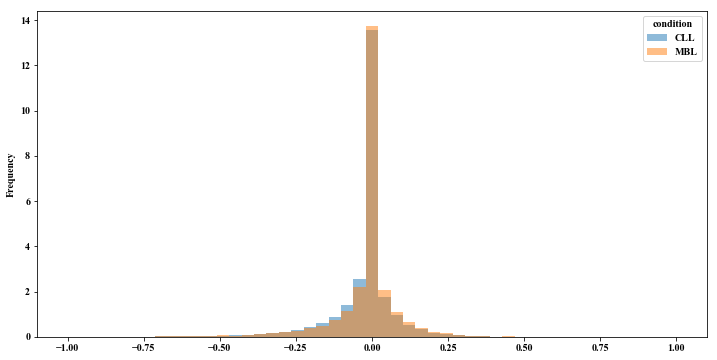

In [12]:
sample_gene_norm = gene_sample_average_norm.T
sample_gene_norm['condition'] = [i[0] for i in sample_gene_norm.index.str.split('_')]
sample_gene_norm.groupby('condition').mean().T.plot(kind='hist', figsize=(12, 6), lw=5,  bins=np.linspace(-1, 1, 50), density=True, alpha=.5)

## Load PPI Network

In [13]:
ppi_network = None
if ppi_network_to_use.upper() == 'IREF':
    net_file = '../data/pancancer/hotnet2/networks/irefindex9/irefindex9_edge_list'
    name_file = '../data/pancancer/hotnet2/networks/irefindex9/irefindex9_index_gene'
    edgelist = pd.read_csv(net_file, sep=' ', header=None,
                           names=['from', 'to', 'weight'])
    index = pd.read_csv(name_file, sep=' ', header=None, names=['name'])
    # build network and relabel nodes to match with real names
    ppi_graph = nx.from_pandas_edgelist(edgelist, source='from', target='to', edge_attr=None)
    _ = nx.relabel_nodes(ppi_graph, index.to_dict()['name'], copy=False)
    ppi_network = nx.to_pandas_adjacency(G=ppi_graph)
    symbols_network_genes = get_ensembl_ids(ppi_network.index)
    # Remove nodes from network that don't have corresponding gene names
    nodes_not_translatable = ppi_network[~ppi_network.index.isin(symbols_network_genes.Symbol)].index
    print ("Not translatable: {}".format(nodes_not_translatable.shape[0]))
    ppi_graph.remove_nodes_from(nodes_not_translatable)
    ppi_network = nx.to_pandas_adjacency(G=ppi_graph)
    assert ((ppi_network.index == symbols_network_genes.Symbol).all())

elif ppi_network_to_use.upper() == 'CPDB':
    ppi_network = pd.read_csv('../data/networks/CPDB_symbols_edgelist.tsv', sep='\t')
    ppi_graph = nx.from_pandas_edgelist(df=ppi_network, source='partner1', target='partner2', edge_attr='confidence')
    ppi_network = nx.to_pandas_adjacency(G=ppi_graph)
else:
    print ("No PPI network named {}".format(ppi_network_to_use))

print ("Edges: {}\tNodes: {}".format(ppi_graph.number_of_edges(), ppi_graph.number_of_nodes()))

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-12129...done.
Finished.
8 input query terms found dup hits:
	[('AHRR', 2), ('ARMCX5-GPRASP2', 2), ('BIRC8', 2), ('FAM27E3', 2), ('KLRC4-KLRK1', 2), ('MEMO1', 2),
784 input query terms found no hit:
	['AARS', 'ABP1', 'ACCN1', 'ACCN2', 'ACCN3', 'ACCN5', 'ACN9', 'ADCK3', 'ADRBK1', 'ADRBK2', 'ADSS', 'A
Not translatable: 0
Edges: 91809	Nodes: 12129


In [14]:
if average_patients:
    features_ppiindex = gene_group_norm.reindex(ppi_network.index, fill_value=0)
else:
    features_ppiindex = gene_sample_average_norm.reindex(ppi_network.index, fill_value=0)
genes_without_data = features_ppiindex.shape[0]-gene_sample_average_norm.index.isin(ppi_network.index).sum()
print ("No data for {} / {} genes. Replacing them with 0".format(genes_without_data, features_ppiindex.shape[0]))

No data for 1617 / 12129 genes. Replacing them with 0


In [15]:
features_ppiindex.head()

,MBL_unmut_1,MBL_unmut_16,MBL_mut_2,MBL_mut_3,MBL_mut_4,MBL_mut_5,MBL_mut_6,MBL_mut_7,MBL_mut_8,MBL_mut_9,...,MBL_2443,MBL_2918,MBL_2958,MBL_2781,MBL_3036,CLL_2443,CLL_2918,CLL_2958,CLL_2781,CLL_3036
A1BG,0.0812,0.0812,-0.2858,-0.2188,0.0812,0.0312,0.0812,0.0812,0.0812,0.0812,...,0.0812,0.0812,0.0812,0.0812,0.0812,0.0812,0.0077,0.0812,0.0187,-0.0028
A1CF,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
A2M,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
AAAS,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
AADAT,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,...,0.0056,0.0056,0.0056,0.0056,0.0056,-0.0344,0.0056,0.0056,0.0056,-0.0784


In [16]:
colors = ['orange' if i =='mut' else 'blue' for i in features_ppiindex.columns.get_level_values('aggressiveness')]
print (colors)
_ = plt.scatter(x=range(features_ppiindex.shape[1]), y=features_ppiindex[features_ppiindex.index == 'CDH2'].values, c=colors)
_ = plt.xticks(range(features_ppiindex.shape[1]), features_ppiindex.columns.get_level_values('timepoint'))

KeyError: 'Level aggressiveness must be same as name (None)'

## Get Labels

In [17]:
nodes = get_ensembl_ids(ppi_network.index)
nodes.columns = ['Name']

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-12129...done.
Finished.
8 input query terms found dup hits:
	[('AHRR', 2), ('ARMCX5-GPRASP2', 2), ('BIRC8', 2), ('FAM27E3', 2), ('KLRC4-KLRK1', 2), ('MEMO1', 2),
784 input query terms found no hit:
	['AARS', 'ABP1', 'ACCN1', 'ACCN2', 'ACCN3', 'ACCN5', 'ACN9', 'ADCK3', 'ADRBK1', 'ADRBK2', 'ADSS', 'A


In [18]:
ncg_known_cancer_genes = []
ncg_candidate_cancer_genes = []
n = 0
with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            ncg_known_cancer_genes.append(l[0])
            ncg_candidate_cancer_genes.append(l[1])
        else:
            ncg_candidate_cancer_genes.append(l[0])

if label_source == 'NCG':
    known_cancer_genes_innet = nodes[nodes.Name.isin(ncg_known_cancer_genes)].Name
    candidate_cancer_genes_innet = nodes[nodes.Name.isin(ncg_candidate_cancer_genes)].Name
    if use_only_blood_cancer_genes:
        # load cgc
        cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv')
        cgc.dropna(subset=['Tissue Type'], inplace=True)
        # find blood cancer genes based on these abbreviations (E=Epithelial, M=Mesenchymal, O=Other, L=Leukaemia/lymphoma)
        pattern = '|'.join(['E', 'M', 'E;'])
        blood_cancer_genes = cgc[~cgc['Tissue Type'].str.contains(pattern)]
        known_cancer_genes_innet = blood_cancer_genes[blood_cancer_genes['Gene Symbol'].isin(nodes.Name)]['Gene Symbol']
        print ("Left with {} known blood cancer genes".format(known_cancer_genes_innet.shape[0]))
    print (known_cancer_genes_innet.shape, len(ncg_known_cancer_genes))

elif label_source == 'expression':
    expression_evidence = pd.read_csv('../data/CLL/digsee_labels/expression_evidence_CLL.txt', sep='\t')
    high_scores = expression_evidence[expression_evidence['EVIDENCE SENTENCE SCORE'] >= 0.4]
    print (high_scores.shape, expression_evidence.shape)
    known_cancer_genes_innet = nodes[nodes.Name.isin(high_scores['GENE SYMBOL'])].Name
    print (known_cancer_genes_innet.shape)

elif label_source == 'methylation':
    print ("There is no methylation information for CLL on DigSEE")
elif label_source == 'mutation':
    mutation_evidence = pd.read_csv('../data/CLL/digsee_labels/mutation_evidence_CLL.txt', sep='\t')
    high_scores = mutation_evidence[mutation_evidence['EVIDENCE SENTENCE SCORE'] >= 0.4]
    print (high_scores.shape, mutation_evidence.shape)
    known_cancer_genes_innet = nodes[nodes.Name.isin(high_scores['GENE SYMBOL'])].Name
    print (known_cancer_genes_innet.shape)
elif label_source == 'digsee_all':
    mutation_evidence = pd.read_csv('../data/CLL/digsee_labels/mutation_evidence_CLL.txt', sep='\t')
    high_scores_mut = mutation_evidence[mutation_evidence['EVIDENCE SENTENCE SCORE'] >= 0.4]

    expression_evidence = pd.read_csv('../data/CLL/digsee_labels/expression_evidence_CLL.txt', sep='\t')
    high_scores_expr = expression_evidence[expression_evidence['EVIDENCE SENTENCE SCORE'] >= 0.4]

    mut_genes_innet = nodes[nodes.Name.isin(high_scores_mut['GENE SYMBOL'])].Name
    expr_genes_innet = nodes[nodes.Name.isin(high_scores_expr['GENE SYMBOL'])].Name

    known_cancer_genes_innet = pd.concat((mut_genes_innet, expr_genes_innet))
    known_cancer_genes_innet = known_cancer_genes_innet.drop_duplicates()
    print (known_cancer_genes_innet.shape)

elif label_source == 'all':
    ncg_cancer_genes_innet = nodes[nodes.Name.isin(ncg_known_cancer_genes)].Name
    if use_only_blood_cancer_genes:
        # load cgc
        cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv')
        cgc.dropna(subset=['Tissue Type'], inplace=True)
        # find blood cancer genes based on these abbreviations (E=Epithelial, M=Mesenchymal, O=Other, L=Leukaemia/lymphoma)
        pattern = '|'.join(['E', 'M', 'E;'])
        blood_cancer_genes = cgc[~cgc['Tissue Type'].str.contains(pattern)]
        ncg_cancer_genes_innet = nodes[nodes.Name.isin(blood_cancer_genes['Gene Symbol'])].Name
        print ("Left with {} known blood cancer genes".format(ncg_cancer_genes_innet.shape[0]))

    mutation_evidence = pd.read_csv('../data/CLL/digsee_labels/mutation_evidence_CLL.txt', sep='\t')
    high_scores_mut = mutation_evidence[mutation_evidence['EVIDENCE SENTENCE SCORE'] >= 0.4]

    expression_evidence = pd.read_csv('../data/CLL/digsee_labels/expression_evidence_CLL.txt', sep='\t')
    high_scores_expr = expression_evidence[expression_evidence['EVIDENCE SENTENCE SCORE'] >= 0.4]

    mut_genes_innet = nodes[nodes.Name.isin(high_scores_mut['GENE SYMBOL'])].Name
    expr_genes_innet = nodes[nodes.Name.isin(high_scores_expr['GENE SYMBOL'])].Name

    known_cancer_genes_innet = pd.concat((ncg_cancer_genes_innet, mut_genes_innet, expr_genes_innet))
    known_cancer_genes_innet = known_cancer_genes_innet.drop_duplicates()
    print (known_cancer_genes_innet.shape)

elif label_source == 'wu':
    labels = pd.read_csv('../data/CLL/labels/labels_wu_et_al.txt', header=None, names=['Name'])
    known_cancer_genes_innet = nodes[nodes.Name.isin(labels.Name)].Name
    print (known_cancer_genes_innet.shape)
else:
    print ("Label Source {} not understood.".format(label_source))

(17,)


In [19]:
print ("{} genes are in network".format(nodes.shape[0]))

# get rid of the positives (known cancer genes)
not_positives = nodes[~nodes.Name.isin(known_cancer_genes_innet)]
print ("{} genes are in network but not in positives (known cancer genes from NCG)".format(not_positives.shape[0]))

# get rid of OMIM genes associated with cancer
omim_cancer_genes = pd.read_csv('../data/pancancer/OMIM/genemap_search_cancer.txt',
                                sep='\t', comment='#', header=0, skiprows=3)
# use fact that nan != nan for filtering out NaN
sublists = [sublist for sublist in omim_cancer_genes['Gene/Locus'].str.split(',') if sublist == sublist]
omim_cancer_geneset = [item.strip() for sublist in sublists for item in sublist]
not_omim_not_pos = not_positives[~not_positives.Name.isin(omim_cancer_geneset)]
print ("{} genes are also not in OMIM cancer genes".format(not_omim_not_pos.shape[0]))

# get rid of all the OMIM disease genes
omim_genes = pd.read_csv('../data/pancancer/OMIM/genemap2.txt', sep='\t', comment='#', header=None)
omim_genes.columns = ['Chromosome', 'Genomic Position Start', 'Genomic Position End', 'Cyto Location',
                      'Computed Cyto Location', 'Mim Number', 'Gene Symbol', 'Gene Name',
                      'Approved Symbol', 'Entrez Gene ID', 'Ensembl Gene ID', 'Comments',
                      'Phenotypes', 'Mouse Gene Symbol/ID']
omim_gene_names = []
for idx, row in omim_genes.iterrows():
    gene_names = row['Gene Symbol'].strip().split(',')
    omim_gene_names += gene_names
omim_gene_names = list(set(omim_gene_names))
not_omim_not_pos = not_omim_not_pos[~not_omim_not_pos.Name.isin(omim_gene_names)]
print ("{} genes are in network but not in oncogenes and not in OMIM".format(not_omim_not_pos.shape[0]))

# remove COSMIC cancer gene census genes
cosmic_gene_scores = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv', header=0)
not_omim_cosmic_pos = not_omim_not_pos[~not_omim_not_pos.Name.isin(cosmic_gene_scores['Gene Symbol'])]
print ("{} genes are also not in COSMIC cancer gene census".format(not_omim_cosmic_pos.shape[0]))

# remove COSMIC highly mutated genes
cosmic_prcoding_mutations = pd.read_csv('../data/pancancer/cosmic/CosmicMutantExportCensus.tsv.gz',
                                        compression='gzip', sep='\t')
non_pos_omim_cosmiccgc_cosmic_mutated = not_omim_cosmic_pos[~not_omim_cosmic_pos.Name.isin(cosmic_prcoding_mutations['Gene name'])]
print ("{} genes are also not in COSMIC mutated genes".format(non_pos_omim_cosmiccgc_cosmic_mutated.shape[0]))

# remove genes that belong to KEGG pathways in cancer
kegg_cancer_pathway_genes = pd.read_csv('../data/pancancer/KEGG/KEGG_genes_in_pathways_in_cancer.txt',
                                        skiprows=2, header=None, names=['Name'])
not_pos_omim_cosmic_kegg = non_pos_omim_cosmiccgc_cosmic_mutated[~non_pos_omim_cosmiccgc_cosmic_mutated.Name.isin(kegg_cancer_pathway_genes.Name)]
print ("{} genes are also not in KEGG cancer pathways".format(not_pos_omim_cosmic_kegg.shape[0]))

# get rid of genes that are not candidate cancer genes
negatives = not_pos_omim_cosmic_kegg[~not_pos_omim_cosmic_kegg.Name.isin(ncg_candidate_cancer_genes)]
print ("{} genes are also not in NCG candidate cancer genes".format(negatives.shape[0]))

"""
# collect genes in KEGG cancer modules
kegg_cancer_module_genes = []
count = 0
with open('../data/pancancer/KEGG/KEGG_cancer_modules.gmt', 'r') as f:
    for line in f:
        for item in line.split('\t')[2:]:
            kegg_cancer_module_genes.append(item.strip())
kegg_cancer_module_genes = list(set(kegg_cancer_module_genes))

# collect genes in KEGG cancer gene neighborhoods
kegg_cancer_neighborhood_genes = []
count = 0
with open('../data/pancancer/KEGG/KEGG_cancer_neighborhoods.gmt', 'r') as f:
    for line in f:
        for item in line.split('\t')[2:]:
            kegg_cancer_neighborhood_genes.append(item.strip())
kegg_cancer_neighborhood_genes = list(set(kegg_cancer_neighborhood_genes))
negatives = negatives[~negatives.Name.isin(kegg_cancer_module_genes) & ~negatives.Name.isin(kegg_cancer_neighborhood_genes)]
print ("{} genes also not in KEGG cancer modules or KEGG cancer gene neighborhoods".format(negatives.shape[0]))
"""

negatives = negatives[~negatives.Name.isin(ncg_known_cancer_genes)]
print ("{} genes are also not in NCG known cancer genes".format(negatives.shape[0]))

# remove very low degree genes to lower the bias
degrees_with_labels = pd.DataFrame(ppi_network.sum(), columns=['Degree'])
neg_w_degrees = degrees_with_labels[degrees_with_labels.index.isin(negatives.Name)]
negatives = negatives[negatives.Name.isin(neg_w_degrees[neg_w_degrees.Degree >= minimum_degree_negatives].index)]
print ("{} genes have a degree >= {}.".format(negatives.shape[0], minimum_degree_negatives))

12129 genes are in network
12112 genes are in network but not in positives (known cancer genes from NCG)
12085 genes are also not in OMIM cancer genes
2136 genes are in network but not in oncogenes and not in OMIM
2096 genes are also not in COSMIC cancer gene census
2095 genes are also not in COSMIC mutated genes
2088 genes are also not in KEGG cancer pathways
1979 genes are also not in NCG candidate cancer genes
1978 genes are also not in NCG known cancer genes
1978 genes have a degree >= 1.


## Train Test Split

In [20]:
y = nodes.Name.isin(known_cancer_genes_innet).values.reshape(-1, 1)
mask = nodes.Name.isin(negatives.Name) | nodes.Name.isin(known_cancer_genes_innet)

In [21]:
y_train, train_mask, y_test, test_mask = gcnPreprocessing.train_test_split(y, mask, 0.25)
y_train, train_mask, y_val, val_mask = gcnPreprocessing.train_test_split(y_train, train_mask, 0.1)
y_train.sum(), train_mask.sum(), y_test.sum(), test_mask.sum(), y_val.sum(), val_mask.sum()

(12, 1346, 4, 499, 1, 150)

In [22]:
features_ppiindex.fillna(0, inplace=True)

## Write HDF5 Container

In [23]:
def write_hdf5_container(fname, adj, F, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask, feature_names):
    f = h5py.File(fname, 'w')
    string_dt = h5py.special_dtype(vlen=str)
    f.create_dataset('network', data=adj, shape=adj.shape)
    f.create_dataset('features', data=F, shape=F.shape)
    f.create_dataset('gene_names', data=node_names, dtype=string_dt)
    f.create_dataset('y_train', data=y_train, shape=y_train.shape)
    f.create_dataset('y_val', data=y_val, shape=y_val.shape)
    f.create_dataset('y_test', data=y_test, shape=y_test.shape)
    f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
    f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
    f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
    f.create_dataset('feature_names', data=np.array(feature_names, dtype=object), dtype=string_dt)
    f.close()

    print ("Container written to {}".format(fname))

In [24]:
nodes['ID'] = nodes.index
nodes = nodes[['ID', 'Name']]
fname = '../data/CLL/methylation_samplewise_wuetallabels.h5'
write_hdf5_container(fname, ppi_network.values, features_ppiindex.values, nodes, y_train,
                     y_val, y_test, train_mask, val_mask, test_mask, features_ppiindex.columns)

Container written to ../data/CLL/methylation_samplewise_wuetallabels.h5


## Dimension Reduction

In [32]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(features_ppiindex.T)

/home/sasse/anaconda3/lib/python3.7/site-packages/umap/umap_.py:1385: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


In [33]:
features_ppiindex.head()

condition                CLL                                                \
aggressiveness           mut                                                 
timepoint                  A         B         C         D       E       F   
A1BG            1.900000e-02  0.028927  0.048927 -0.017229  0.0719  0.0812   
A1CF            0.000000e+00  0.000000  0.000000  0.000000  0.0000  0.0000   
A2M             0.000000e+00  0.000000  0.000000  0.000000  0.0000  0.0000   
AAAS            0.000000e+00  0.000000  0.000000  0.000000  0.0000  0.0000   
AADAT           5.551115e-17  0.005600 -0.004582  0.005600 -0.0126 -0.0944   

condition                                                              MBL  \
aggressiveness unknown   unmut                                         mut   
timepoint            Z       A       B         C       D       E         Z   
A1BG            0.0372  0.0285 -0.0022 -0.076943 -0.0206 -0.1413  0.002589   
A1CF            0.0000  0.0000  0.0000  0.000000  0.0000  0.0000  0.000000   
A2M             0.0000  0.0000  0.0000  0.000000  0.0000  0.0000  0.000000   
AAAS            0.0000  0.0000  0.0000  0.000000  0.0000  0.0000  0.000000   
AADAT          -0.0192  0.0031 -0.0041 -0.021257 -0.0231 -0.0029  0.005600   

condition                       
aggressiveness unknown   unmut  
timepoint            Z       Z  
A1BG            0.0812  0.0812  
A1CF            0.0000  0.0000  
A2M             0.0000  0.0000  
AAAS            0.0000  0.0000  
AADAT           0.0056  0.0056

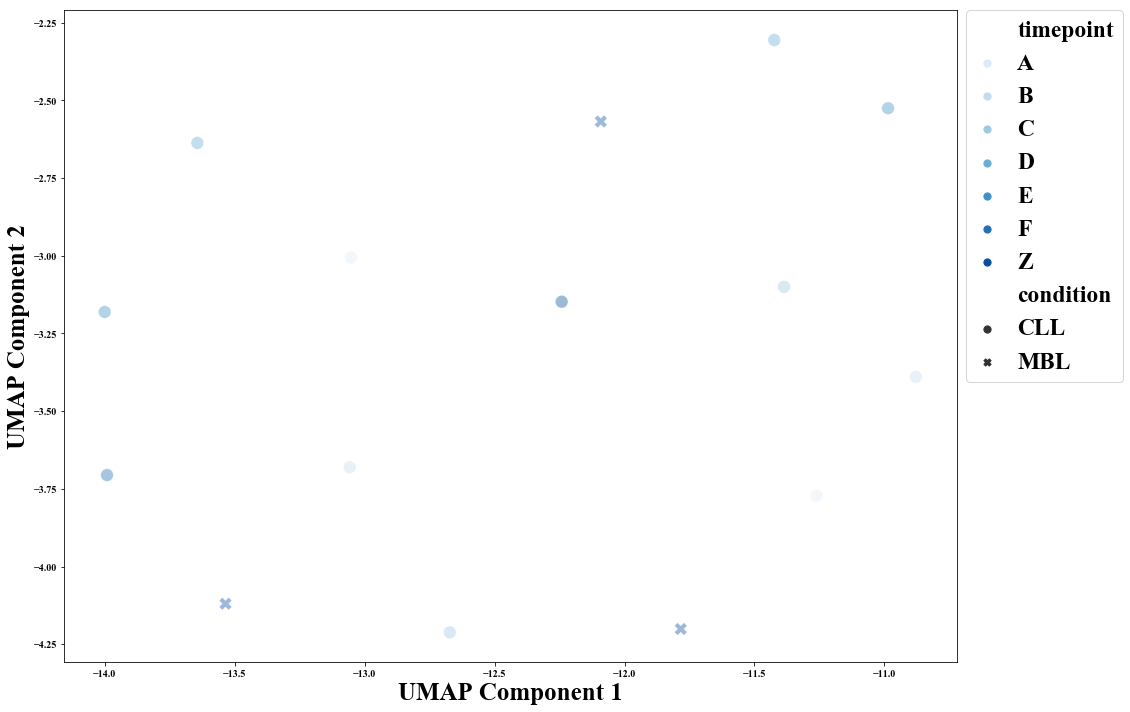

In [56]:
emb_df = pd.DataFrame(embedding, index=features_ppiindex.columns, columns=['PC1', 'PC2'])
emb_df['condition'] = features_ppiindex.columns.get_level_values('condition')
emb_df['timepoint'] = features_ppiindex.columns.get_level_values('timepoint')
emb_df['aggressiveness'] = features_ppiindex.columns.get_level_values('aggressiveness')
fig = plt.figure(figsize=(16, 12))
g = sns.scatterplot(data=emb_df, x='PC1', y='PC2', hue='timepoint', style='condition', 
                    alpha=0.4, s=160, palette=sns.color_palette("Blues", n_colors=emb_df.timepoint.nunique()))
g.set_xlabel('UMAP Component 1', fontsize=25)
g.set_ylabel('UMAP Component 2', fontsize=25)
legend = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size': 23.5}, handlelength=1,
                    markerscale=1.2)
#g.legend_.remove()
#legend.texts[0].set_text(r"$\bf{Tissue}$")
#legend.texts[17].set_text(r"$\bf{Type}$")
#g.set_title('UMAP Embedding (Tumor, Normal, GTEx) for RSEM read counts (no normalization)', fontsize=35)